In [1]:
%%capture

%pip install -U ultralytics sahi

!pip install --trusted-host pypi.python.org moviepy
!pip install imageio-ffmpeg

In [2]:

import ultralytics
from ultralytics import YOLO

from sahi import AutoDetectionModel
from sahi.predict import get_prediction, get_sliced_prediction, predict


from IPython.display import display, Image, Video, HTML
import torch

from matplotlib import pyplot as plt
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
# from IPython import display
# display.clear_output()

ultralytics.checks()

Ultralytics YOLOv8.2.76  Python-3.10.9 torch-1.13.1+cpu CPU (Intel Core(TM) i3-1005G1 1.20GHz)
Setup complete  (4 CPUs, 7.8 GB RAM, 21.7/150.0 GB disk)


In [4]:
class Config:
    # Define the local paths for your files and folders
    crosswalk_folder = r'G:\alert system\crosswalk-2'
    train_results = r'G:\alert system\runs\detect\train'
    infe_video = r'G:\alert system\walk.mp4'
    output_path = r'G:\alert system\output_video.mp4'
    output_path_sahi = r'G:\alert system\output_video_sahi.mp4'
    
    # Other configuration parameters
    conf = 0.2
    weights = r'G:\alert system\yolov8x.pt'

In [5]:
def process_local_video(input_path: str, output_path: str, start_time: float, end_time: float):

    try:
        # Extract the subclip
        ffmpeg_extract_subclip(input_path, start_time, end_time, targetname=output_path)

    except Exception as e:
        print(f"An error occurred: {e}")

# Define paths and times
local_video_path = r'G:\alert system\video.mp4'
subclip_path = Config.infe_video
start_time = 2.3 * 60  # time in seconds
end_time = 2.6 * 60


In [6]:
process_local_video(input_path=local_video_path, output_path=subclip_path, start_time=start_time, end_time=end_time)

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


In [7]:
frac = 0.5
Video(data=Config.infe_video, height=int(720*frac), width=int(1280*frac), embed=True)

In [8]:
device =  'cuda:0' if torch.cuda.is_available() else 'cpu'

In [9]:
coco_classes = [0, 2]  # person and car

# Use the path directly from Config
model = YOLO(Config.weights)

sahi_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=Config.weights,  # Directly use Config.weights
    confidence_threshold=Config.conf,
    device=device  # Ensure 'device' is defined, e.g., 'cuda' or 'cpu'
)

100%|██████████| 131M/131M [02:06<00:00, 1.08MB/s] 


In [10]:
import cv2
import numpy as np
import random

def extractImages(pathIn, pathOut):
    '''
    Extract one frame of video
    '''
    vidcap = cv2.VideoCapture(pathIn)
    if not vidcap.isOpened():
        print(f"Error: Could not open video file {pathIn}")
        return
    
    frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    
    if fps == 0:
        print("Error: FPS is zero, cannot proceed.")
        return
    
    list_ts = [second for second in range(int(frames / fps))]
    choic_ts = random.choice(list_ts)
    
    # Set video position to the chosen timestamp
    vidcap.set(cv2.CAP_PROP_POS_MSEC, choic_ts * 1000)
    
    success, image = vidcap.read()
    if not success:
        print("Error: Could not read the frame.")
        return
    
    cv2.imwrite(pathOut, image)  # save frame as JPEG file
    vidcap.release()

def drawBBox(df_coords, img, thickness=1):
    cords = df_coords[['xmin', 'xmax', 'ymin', 'ymax']].values.astype(int)
    classes = df_coords['class'].values

    for i, person_cords in enumerate(cords):
        start_point = (person_cords[0], person_cords[3])  # x_min, y_max
        end_point = (person_cords[1], person_cords[2])  # x_max, y_min
        class_detected = classes[i]
        
        color = (255, 0, 0)  # default color
        if class_detected == 'car':
            color = (255, 0, 0)  # red: in danger
        elif class_detected == 'person':
            color = (255, 0, 0)  # blue: not in danger
        elif class_detected == 'crosswalk':
            color = (28, 226, 233)  # cyan
        
        cv2.rectangle(img, start_point, end_point, color, thickness)
    
    return img

def createPolygon(img, dict_vertices):
    '''
    Draw a polygon in an image
    '''
    for vertices in dict_vertices.values():
        cv2.polylines(img, [vertices.reshape(-1, 1, 2)], True, (0, 0, 255), 2)
        mod = img.copy()
        cv2.fillPoly(mod, pts=[vertices], color=(0, 0, 255))
        img = cv2.addWeighted(img, 0.9, mod, 0.1, 0)
    
    return img

def detectPersonRisck(frame_df, dict_vertices, img, thickness=1):
    '''
    - Draw bbox for detections
    - Flag detections in Polygons Risks
    '''
    count_person_roi = 0
    risk_detections = [0] * len(frame_df)
    img = createPolygon(img=img, dict_vertices=dict_vertices)
    classes = frame_df['class'].values
    
    for i, person_detected in enumerate(frame_df[['xmin', 'xmax', 'ymin', 'ymax']].values.astype(int)):
        start_point = (person_detected[0], person_detected[3])  # x_min, y_max
        end_point = (person_detected[1], person_detected[2])  # x_max, y_min
        class_detected = classes[i]
        title_x = int(person_detected[0] + ((person_detected[1] - person_detected[0]) / 2))
        title_y = int(person_detected[2] - (person_detected[2] * 0.05))
        
        if class_detected == 'car':
            cv2.rectangle(img, start_point, end_point, (255, 0, 0), thickness)  # red: in danger
            cv2.putText(img, 'C', (title_x, title_y), cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 0, 0), 2)
        elif class_detected == 'person':
            foot_1 = (int(person_detected[0]), int(person_detected[3]))
            foot_2 = (int(person_detected[1]), int(person_detected[3]))

            person_detected_in_risk = False
            for vertices in dict_vertices.values():
                if cv2.pointPolygonTest(vertices, foot_1, False) >= 0 or cv2.pointPolygonTest(vertices, foot_2, False) >= 0:
                    person_detected_in_risk = True
                    count_person_roi += 1
                    risk_detections[i] = 1

            color_bbox_person = (0, 0, 255) if person_detected_in_risk else (0, 255, 0)
            cv2.rectangle(img, start_point, end_point, color_bbox_person, thickness)
            cv2.putText(img, 'P', (title_x, title_y), cv2.FONT_HERSHEY_TRIPLEX, 1, color_bbox_person, 2)
        elif class_detected == 'crosswalk':
            cv2.rectangle(img, start_point, end_point, (28, 226, 233), thickness)
    
    return count_person_roi, risk_detections, img


In [11]:
import pandas as pd
import cv2

def build_sahi_results(result_sahi_obj):
    '''
    Extract bounding boxes, class IDs, and confidence scores from SAHI results.
    '''
    object_prediction_list = result_sahi_obj.object_prediction_list
    res_sahi_list = []  # bbox + class

    for prediction in object_prediction_list:
        boxes = (prediction.bbox.minx, prediction.bbox.miny,
                 prediction.bbox.maxx, prediction.bbox.maxy)
        clss = prediction.category.id
        conf = prediction.score.value
        boxes = list(boxes)

        if clss in coco_classes:
            res_sahi_list.append(boxes + [conf, clss])
    
    return res_sahi_list

def pipeline_from_predictions(result_array, img, croswalk_points):
    '''
    Process predictions to detect persons and draw bounding boxes.
    '''
    # Convert result_array to DataFrame
    position_frame = pd.DataFrame(result_array, 
                                  columns=['xmin', 'ymin', 'xmax', 'ymax', 'conf', 'class'])

    # Replace class IDs with class names
    position_frame['class'] = position_frame['class'].replace({0: 'person', 2: 'car'})

    # Detect person risk and draw bounding boxes
    count_person_roi, risk_detections, bbox_image = detectPersonRisck(position_frame, 
                                                                     croswalk_points, 
                                                                     img)

    # Get video dimensions
    video_height, video_width, _ = bbox_image.shape

    # Add danger text overlay
    cv2.putText(bbox_image, f'Danger: {count_person_roi}', 
                (video_width - 200, video_height - 50), 
                cv2.FONT_HERSHEY_PLAIN, 
                2, 
                (0, 0, 255), 
                2)
    
    return bbox_image


In [37]:
import numpy as np
import cv2

# Extract a frame of video to example image
extractImages(Config.infe_video, './image.png')

# Polygon points of risk areas
croswalk_points = {
    1: np.array([[223, 607], [135, 400], [227, 299], [570, 147], [682, 133], [826, 148], [900, 205], [428, 603]], dtype=int),
    2: np.array([[179, 274], [37, 199], [176, 121], [491, 136]], dtype=int),
    3: np.array([[852, 123], [725, 108], [822, 58], [900, 81]], dtype=int),
}

# Read the example image
exp_image = cv2.imread('./image.png')
exp_image_sahi = cv2.imread('./image.png')

# Inference with YOLO model
results = model.predict(exp_image, 
                        conf=0.5, 
                        classes=coco_classes, 
                        device=device, 
                        verbose=False)

# Inference with SAHI model
result_sahi = get_sliced_prediction(
    exp_image_sahi,
    sahi_model,
    slice_height=256,
    slice_width=256,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
    verbose=True
)

# Build SAHI results
res_sahi_list = build_sahi_results(result_sahi)

# Process YOLO results
bbox_image = pipeline_from_predictions(result_array=results[0].cpu().numpy().boxes.data, 
                                        img=exp_image,
                                        croswalk_points=croswalk_points)

# Process SAHI results
bbox_image_sahi = pipeline_from_predictions(result_array=res_sahi_list, 
                                            img=exp_image_sahi,
                                            croswalk_points=croswalk_points)

# Save the images with bounding boxes
cv2.imwrite('./image_yolo.png', bbox_image)
cv2.imwrite('./image_sahi.png', bbox_image_sahi)


Performing prediction on 24 slices.


True

Yolo Prediction


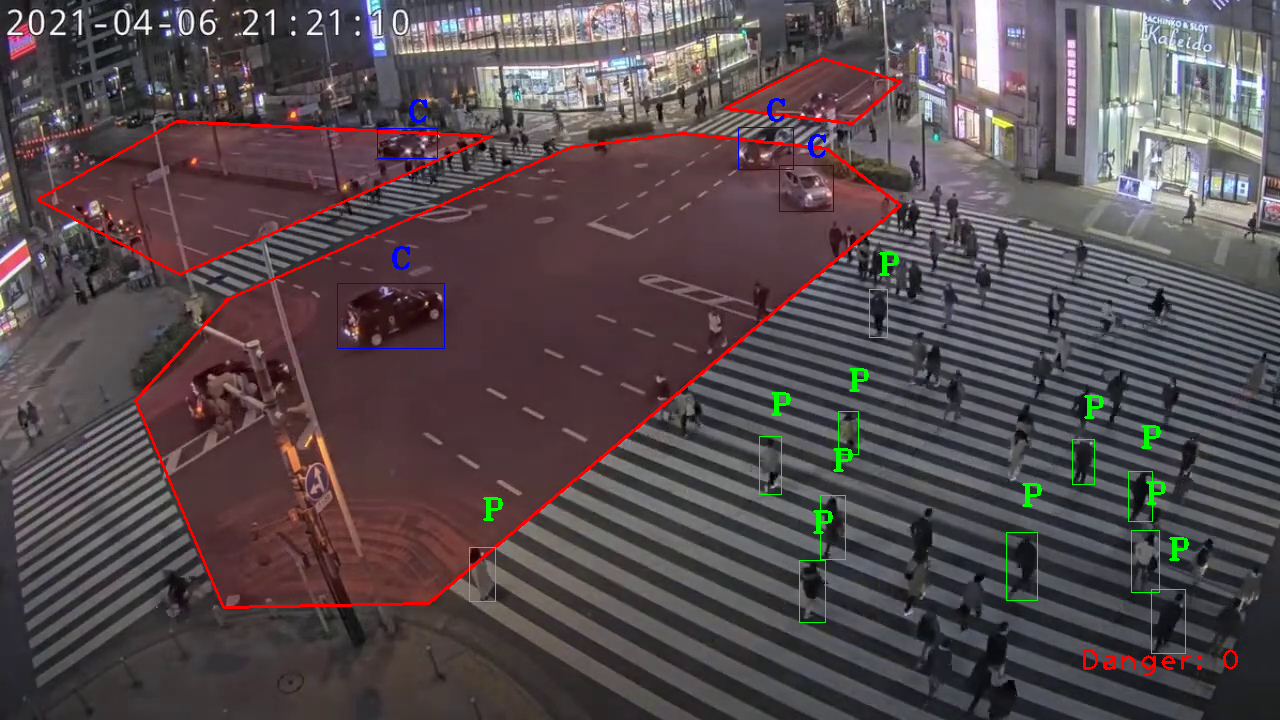

In [38]:
print('Yolo Prediction')
Image('./image_yolo.png')

SAHI Prediction


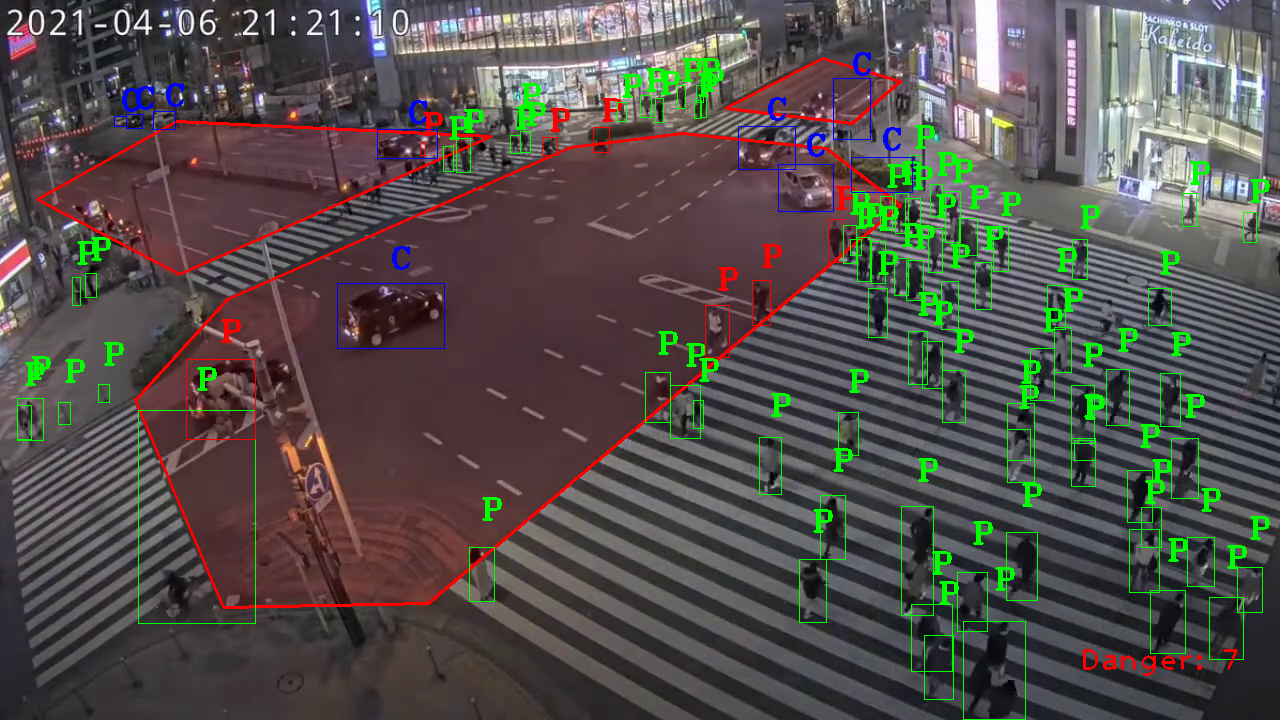

In [39]:
print('SAHI Prediction')
Image('./image_sahi.png')

In [53]:
import cv2
import numpy as np

def count_detected_persons(image_path, color_threshold=(0, 0, 255), min_area=5):
    
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_bound = np.array([color_threshold[0] - 10, 100, 100])
    upper_bound = np.array([color_threshold[0] + 10, 255, 255])

    mask = cv2.inRange(hsv, lower_bound, upper_bound)
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    person_count = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_area:
            person_count += 1

    return person_count

# Count persons in both YOLO and SAHI predicted images
yolo_person_count = count_detected_persons('./image_yolo.png')
sahi_person_count = count_detected_persons('./image_sahi.png')

# Print the results
print(f'Number of persons detected in YOLO prediction: {yolo_person_count}')
print(f'Number of persons detected in SAHI prediction: {sahi_person_count}')

# Performance comparison (if you have a ground truth value)
# For demonstration, assume you have a ground truth of 10 persons
ground_truth_person_count = 10

yolo_performance = yolo_person_count / ground_truth_person_count
sahi_performance = sahi_person_count / ground_truth_person_count

print(f'YOLO detection performance: {yolo_performance:.2f}')
print(f'SAHI detection performance: {sahi_performance:.2f}')


Number of persons detected in YOLO prediction: 77
Number of persons detected in SAHI prediction: 123
YOLO detection performance: 7.70
SAHI detection performance: 12.30


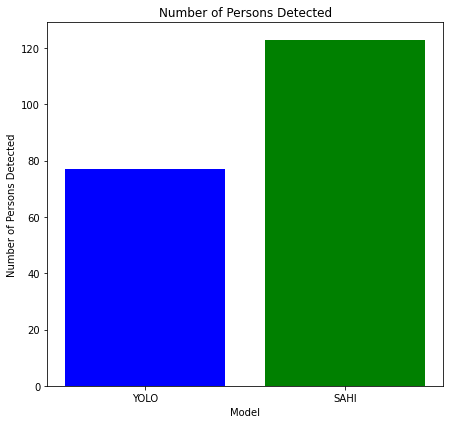

In [60]:
models = ['YOLO', 'SAHI']
detected_counts = [yolo_person_count, sahi_person_count]
performances = [yolo_performance, sahi_performance]

# Create the bar graph for detected counts
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(models, detected_counts, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Number of Persons Detected')
plt.title('Number of Persons Detected')

# Show the plot
plt.tight_layout()
plt.show()

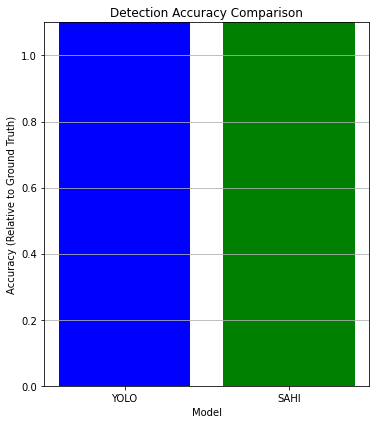

In [61]:
models = ['YOLO', 'SAHI']
detected_counts = [yolo_person_count, sahi_person_count]
ground_truth_count = 10  # Example ground truth value

# Calculate the performance metrics (accuracy) as a fraction of ground truth
performance = [count / ground_truth_count for count in detected_counts]

# Create a bar plot for detected counts
plt.figure(figsize=(10, 6))


# Plot the accuracy of the detections
plt.subplot(1, 2, 2)
plt.bar(models, performance, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy (Relative to Ground Truth)')
plt.title('Detection Accuracy Comparison')
plt.ylim(0, 1.1)  # Set y-axis limit to show accuracy as a percentage
plt.grid(axis='y')

# Show the plots
plt.tight_layout()
plt.show()

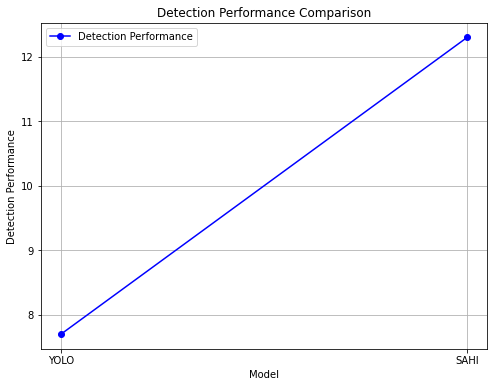

In [62]:
import matplotlib.pyplot as plt

models = ['YOLO', 'SAHI']
performance = [7.70, 12.30]

x_axis = list(range(len(models)))


plt.figure(figsize=(8, 6))
plt.plot(x_axis, performance, marker='o', linestyle='-', color='b', label='Detection Performance')
plt.xticks(x_axis, models)  # Set x-axis labels to model names
plt.xlabel('Model')
plt.ylabel('Detection Performance')
plt.title('Detection Performance Comparison')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


In [15]:
from tqdm import tqdm
import cv2
import os
import subprocess

# Open the video file
cap = cv2.VideoCapture(Config.infe_video)

# Get video properties
video_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
size = (video_width, video_height)
fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
fourcc = cv2.VideoWriter_fourcc(*'MP4V')

# Temporary output path
tmp_output_path = './tmp_output_video.mp4'

# Create video writer
out = cv2.VideoWriter(tmp_output_path, fourcc, fps, size)

# Process each frame in the video
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
for _ in tqdm(range(frame_count), desc="Processing Video", unit="frame"):
    frame_exists, frame = cap.read()
    
    if frame_exists:
        # YOLO model prediction
        results = model.predict(
            frame, 
            conf=Config.conf, 
            classes=coco_classes, 
            device=device, 
            verbose=False
        )

        # Process YOLO results
        bbox_image = pipeline_from_predictions(
            result_array=results[0].boxes.data.cpu().numpy(), 
            img=frame, 
            croswalk_points=croswalk_points
        )
        
        # Write processed frames to video
        out.write(bbox_image)
        
    else:
        print("\nCan't receive frame (stream end?). Exiting...\n")
        break

# Release resources
cap.release()
out.release()

# Remove existing output files if they exist
if os.path.exists(Config.output_path):
    os.remove(Config.output_path)

# Convert temporary video files to final output format
subprocess.run([
    "ffmpeg", "-i", tmp_output_path, "-crf", "18", "-preset", "veryfast",
    "-hide_banner", "-loglevel", "error", "-vcodec", "libx264", Config.output_path
])

# Remove temporary video files
os.remove(tmp_output_path)


Processing Video:  94%|█████████▎| 540/577 [21:06<01:26,  2.35s/frame]



Can't receive frame (stream end?). Exiting...



In [1]:
frac = 0.7
display(Video(data=Config.output_path, height=int(720*frac), width=int(1280*frac), embed=True))

NameError: name 'Video' is not defined

In [ ]:
from tqdm import tqdm
import cv2
import os
import subprocess

# Open the video file
cap = cv2.VideoCapture(Config.infe_video)

# Get video properties
video_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
size = (video_width, video_height)
fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
fourcc = cv2.VideoWriter_fourcc(*'MP4V')

# Temporary output paths

tmp_output_path_sahi = './tmp_output_video_sahi.mp4'

# Create video writers

out_sahi = cv2.VideoWriter(tmp_output_path_sahi, fourcc, fps, size)

# Process each frame in the video
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
for _ in tqdm(range(frame_count), desc="Processing Video", unit="frame"):
    frame_exists, frame = cap.read()
    
    if frame_exists:
        

        # SAHI model prediction
        result_sahi = get_sliced_prediction(
            frame,
            sahi_model,
            slice_height=256,
            slice_width=256,
            overlap_height_ratio=0.2,
            overlap_width_ratio=0.2,
            verbose=False
        )

        # Build SAHI results
        res_sahi_list = build_sahi_results(result_sahi)

        
        # Process SAHI results
        bbox_image_sahi = pipeline_from_predictions(result_array=res_sahi_list, 
                                                    img=frame, 
                                                    croswalk_points=croswalk_points)
        
        # Write processed frames to video
        
        out_sahi.write(bbox_image_sahi)
    else:
        print("\nCan't receive frame (stream end?). Exiting...\n")
        break

# Release resources
cap.release()

out_sahi.release()
cv2.destroyAllWindows()

# Remove existing output files if they exist

    
if os.path.exists(Config.output_path_sahi):
    os.remove(Config.output_path_sahi)

# Convert temporary video files to final output format


subprocess.run([
    "ffmpeg", "-i", tmp_output_path_sahi, "-crf", "18", "-preset", "veryfast",
    "-hide_banner", "-loglevel", "error", "-vcodec", "libx264", Config.output_path_sahi
])

# Remove temporary video files

os.remove(tmp_output_path_sahi)


In [ ]:
frac = 0.7
display(Video(data=Config.output_path_sahi, height=int(720*frac), width=int(1280*frac), embed=True))